<a href="https://colab.research.google.com/github/Jalapinho1/Deep-Reinforcement-Learning-Explained/blob/main/Value_Iteration_Q_function.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Value Iteration for Q-function**

We will review the Q-function and present the Value Iteration method that learns the values of the actions to create a policy.

As we will see later in this post, Q-values are much **more convenient** in practice, as for the Agent, it’s much simpler to make decisions about actions based on Q-values than on V-values.

Based on the previous Value Iteration method implementation for V-function, in the case of action values, only minor modifications to the preceding code are required. The most obvious change is to our **value table**. In the previous case, we kept the value of the state, so the key in the dictionary was just a state. Now we need to store **values of the Q-function**, which has two parameters: **state and action**, so the key in the value table is now a composite

the optimal value of the action-state can be defined as:

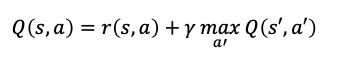

**Value Iteration with Q-function in Practice**

The central data which will keep our tables and the functions, that we will be using in the training loop, are the same as the previous example of V-function. The main change is into the values table, a dictionary that now maps a state-action pair into the calculated value of this action.

In the previous case, we kept the value of the state, so the key in the dictionary was just a state. Now we need to store values of the Q-function, which has two parameters: state and action, so the key in the value table is now a composite. This implies that another difference is in the *calc_action_value* function. We just don’t need it anymore, as our action values are stored in the value table.


Finally, the most important change in the code is in the Agent’s *value_iteration()* method. Before, it was just a wrapper around the *calc_action_value()* call, which did the job of Bellman approximation. Now, as this function has gone and been replaced by a value table, we need to do this approximation in the *value_iteration()* method.

**Frozen-Lake code for Q-function**

Code is almost the same from the previous implementation: https://github.com/Jalapinho1/Deep-Reinforcement-Learning-Explained/blob/main/Value_Iteration_V_function.ipynb.

```
def value_iteration_for_Q(self):
    for state in range(self.env.observation_space.n):
        for action in range(self.env.action_space.n):
            action_value = 0.0
            target_counts = self.transits[(state, action)]
            total = sum(target_counts.values())
            for tgt_state, count in target_counts.items():
                key = (state, action, tgt_state)
                reward = self.rewards[key]
                best_action = self.select_action(tgt_state)
                val = reward + GAMMA * \
                      self.values[(tgt_state, best_action)]
                action_value += (count / total) * val
           self.values[(state, action)] = action_value
```

The idea is that for a given state and action, it needs to calculate the action value using the information we collected by the function *play_n_random_steps* that plays N random steps from the Environment, populating the reward and transits tables with random experiences.

However, in the previous implementation, we had the V-function stored in the value table, so we just took it from this table. We can’t do this anymore, so we have to call the *select_action* method, which will choose for us the best action with the largest Q-value, and then we take this Q-value as the value of the target state.

In fact, this method is implemented differently, as it no longer calls the *calc_action_value* method but we just iterate over the actions and look up their values in our values table.

```
def select_action(self, state):
    best_action, best_value = None, None
    for action in range(self.env.action_space.n):
        action_value = self.values[(state, action)]
        if best_value is None or best_value < action_value:
           best_value = action_value
           best_action = action
    return best_action
```

**Implementation**

In [3]:
import gym 
import collections
from torch.utils.tensorboard import SummaryWriter

ENV_NAME = "FrozenLake-v0"
#ENV_NAME = "FrozenLake8x8-v0"  
GAMMA = 0.9
TEST_EPISODES = 20
REWARD_GOAL = 0.8
N =100


class Agent:
    def __init__(self):
        self.env = gym.make(ENV_NAME)
        self.state = self.env.reset()
        self.rewards = collections.defaultdict(float)
        self.transits = collections.defaultdict(
            collections.Counter)
        self.values = collections.defaultdict(float)

    def play_n_random_steps(self, count):
        for _ in range(count):
            action = self.env.action_space.sample()
            new_state, reward, is_done, _ = self.env.step(action)
            self.rewards[(self.state, action, new_state)] = reward
            self.transits[(self.state, action)][new_state] += 1
            if is_done:
                self.state = self.env.reset() 
            else: 
                self.state = new_state

    def calc_action_value(self, state, action):
        target_counts = self.transits[(state, action)]
        total = sum(target_counts.values())
        action_value = 0.0
        for tgt_state, count in target_counts.items():
            reward = self.rewards[(state, action, tgt_state)]
            val = reward + GAMMA * self.values[tgt_state]
            action_value += (count / total) * val
        return action_value


    def select_action(self, state):
        best_action, best_value = None, None
        for action in range(self.env.action_space.n):
            action_value = self.values[(state, action)]
            if best_value is None or best_value < action_value:
                best_value = action_value
                best_action = action
        return best_action


    def value_iteration_for_Q(self):
        for state in range(self.env.observation_space.n):
            for action in range(self.env.action_space.n):
                action_value = 0.0
                target_counts = self.transits[(state, action)]
                total = sum(target_counts.values())
                for tgt_state, count in target_counts.items():
                    key = (state, action, tgt_state)
                    reward = self.rewards[key]
                    best_action = self.select_action(tgt_state)
                    val = reward + GAMMA * \
                          self.values[(tgt_state, best_action)]
                    action_value += (count / total) * val
                self.values[(state, action)] = action_value

In [4]:
# TRAINING
test_env = gym.make(ENV_NAME)
agent = Agent()
writer = SummaryWriter()

iter_no = 0
best_reward = 0.0
 
while best_reward < REWARD_GOAL:
        
        agent.play_n_random_steps(N)

        agent.value_iteration_for_Q()

        iter_no += 1
        reward_test = 0.0
        for _ in range(TEST_EPISODES):
            total_reward = 0.0
            state = test_env.reset()
            while True:
                action = agent.select_action(state)
                new_state, new_reward, is_done, _ = test_env.step(action)
                total_reward += new_reward
                if is_done: break
                state = new_state
            reward_test += total_reward
        reward_test /= TEST_EPISODES

        writer.add_scalar("reward", reward_test, iter_no)
        if reward_test > best_reward:
            print("Best reward updated %.2f at iteration %d " % (reward_test ,iter_no) )
            best_reward = reward_test

writer.close()

Best reward updated 0.05 at iteration 7 
Best reward updated 0.10 at iteration 8 
Best reward updated 0.65 at iteration 9 
Best reward updated 0.80 at iteration 10 


In [5]:
new_test_env = gym.make(ENV_NAME) 
state = new_test_env.reset()
new_test_env.render()
is_done = False
iter_no = 0
while not is_done:
     print (state)
     action = agent.select_action(state)
     new_state, reward, is_done, _ = new_test_env.step(action)
     test_env.render()
     state = new_state
     iter_no +=1
print("reward =    ", reward)
print("iterations =", iter_no)


SFFF
FHFH
FFFH
HFFG
0
  (Down)
SFFF
FHFH
FFFH
HFFG
0
  (Down)
SFFF
FHFH
FFFH
HFFG
0
  (Down)
SFFF
FHFH
FFFH
HFFG
0
  (Down)
SFFF
FHFH
FFFH
HFFG
0
  (Down)
SFFF
FHFH
FFFH
HFFG
4
  (Down)
SFFF
FHFH
FFFH
HFFG
8
  (Down)
SFFF
FHFH
FFFH
HFFG
9
  (Down)
SFFF
FHFH
FFFH
HFFG
8
  (Down)
SFFF
FHFH
FFFH
HFFG
4
  (Down)
SFFF
FHFH
FFFH
HFFG
0
  (Down)
SFFF
FHFH
FFFH
HFFG
0
  (Down)
SFFF
FHFH
FFFH
HFFG
0
  (Down)
SFFF
FHFH
FFFH
HFFG
0
  (Down)
SFFF
FHFH
FFFH
HFFG
0
  (Down)
SFFF
FHFH
FFFH
HFFG
0
  (Down)
SFFF
FHFH
FFFH
HFFG
4
  (Down)
SFFF
FHFH
FFFH
HFFG
4
  (Down)
SFFF
FHFH
FFFH
HFFG
8
  (Down)
SFFF
FHFH
FFFH
HFFG
8
  (Down)
SFFF
FHFH
FFFH
HFFG
8
  (Down)
SFFF
FHFH
FFFH
HFFG
4
  (Down)
SFFF
FHFH
FFFH
HFFG
4
  (Down)
SFFF
FHFH
FFFH
HFFG
8
  (Down)
SFFF
FHFH
FFFH
HFFG
9
  (Down)
SFFF
FHFH
FFFH
HFFG
13
  (Down)
SFFF
FHFH
FFFH
HFFG
13
  (Down)
SFFF
FHFH
FFFH
HFFG
13
  (Down)
SFFF
FHFH
FFFH
HFFG
13
  (Down)
SFFF
FHFH
FFFH
HFFG
14
  (Down)
SFFF
FHFH
FFFH
HFFG
reward =     1.0
iterations = 30


In [6]:
%load_ext tensorboard


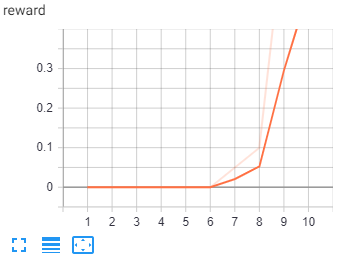

**CONCLUSIONS**

Q-values are much more convenient in practice, as for the agent, it’s much simpler to make decisions about actions based on Q-values than on V-values. In the case of Q-values, to choose the action based on the state, the agent just needs to calculate Q-value for all available actions using the current state and choose the action with the largest Q-value.

To do the same using values of the states, **V-value**, the agent **needs to know not only values but also probabilities for transitions**. In practice, we **rarely** know them in advance, so the agent needs to estimate transition probabilities for every action and state pair.

In the Value Iteration method for V-function, this dependency on probability adds an extra burden for the agent. That said, it is important to know this method because they are an essential part of advanced methods.
